In [97]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [98]:
steps = 125
traj_num = 220
Nstates = 15
udim = 1

In [99]:
train_data = np.empty((steps, traj_num, Nstates + udim))
platoon_data = np.genfromtxt('C:/Users/tkx19/Documents/GitHub/DeepKoopmanWithControl/LSTM/state16.csv', delimiter=",")
print("platoon_data shape:", platoon_data.shape)
for traj_i in range(traj_num):
            for step_i in range(steps):
                index = steps * traj_i + step_i
                #print('platoon data index',index)
                if index < platoon_data.shape[1]:
                    train_data[step_i, traj_i, :] = platoon_data[:, index]

print(train_data.shape)

platoon_data shape: (16, 27500)
(125, 220, 16)


In [100]:
df = pd.DataFrame(platoon_data).T
# df = pd.read_csv('data_4.csv')
print(df)

              0      1      2      3      4      5          6          7   \
0       2.082824  59.91  61.19  51.06  54.48  43.57  19.289263  15.555429   
1       2.013669  59.11  61.83  50.42  55.42  43.62  19.364155  15.470308   
2       2.028362  58.45  62.46  49.80  56.25  43.77  19.371841  15.398211   
3       2.131772  57.89  63.06  49.18  56.89  44.12  19.388317  15.339132   
4       2.307491  57.36  63.67  48.56  57.31  44.68  19.387648  15.292855   
...          ...    ...    ...    ...    ...    ...        ...        ...   
27495  -8.657854  72.04  96.62  52.64  47.07  58.06  41.311685  35.989751   
27496  -8.945805  72.03  96.75  52.88  47.03  58.25  41.565450  36.097555   
27497  -9.246326  72.02  97.01  53.12  46.90  58.46  41.735181  36.184247   
27498  -9.611439  71.99  97.36  53.38  46.72  58.66  41.825989  36.248001   
27499 -10.060854  71.86  97.75  53.71  46.52  58.85  41.842708  36.289964   

              8          9          10        11        12        13  \
0  

In [101]:
scaled_df = pd.DataFrame(data=df, columns=df.columns)
scaled = scaled_df.to_numpy()
print(scaled.shape)
print(scaled)

(27500, 16)
[[  2.08282372  59.91        61.19       ...  -4.06946359   3.52434977
    4.57194027]
 [  2.01366915  59.11        61.83       ...  -4.26914422   3.36080556
    4.85051403]
 [  2.02836224  58.45        62.46       ...  -4.44642274   3.17523658
    5.16538001]
 ...
 [ -9.24632594  72.02        97.01       ...   2.02115795  -0.25358584
    3.49959305]
 [ -9.61143904  71.99        97.36       ...   1.96137235  -0.24766105
    3.43077843]
 [-10.06085445  71.86        97.75       ...   1.86122762  -0.21910309
    3.34044972]]


In [102]:
# create time series for the historical data
def create_sequence(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence(t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [135]:
n_timeframes = 10
n_features = scaled.shape[1]
print(n_features)
seq_length = n_timeframes
pred_length = 10

i = 0
refr_x = []
refr_y = []
refr = []
for traj_i in range(50):
    df = scaled[traj_i*500:traj_i*500+500]
    ref = create_sequence(df, seq_length, pred_length)
    ref.drop(ref.columns[list(range(-n_features, -16))], axis=1, inplace=True)
    refr.append(ref)
# print(refr.shape)
reframed_org = pd.concat(refr, ignore_index=True)
print(reframed_org.shape)
print(reframed_org)

16
(24050, 320)
       var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var5(t-10)  var6(t-10)  \
0        2.082824       59.91       61.19       51.06       54.48       43.57   
1        2.013669       59.11       61.83       50.42       55.42       43.62   
2        2.028362       58.45       62.46       49.80       56.25       43.77   
3        2.131772       57.89       63.06       49.18       56.89       44.12   
4        2.307491       57.36       63.67       48.56       57.31       44.68   
...           ...         ...         ...         ...         ...         ...   
24045    3.411440       47.23       44.14       49.18       40.34       53.48   
24046    3.466485       48.35       44.54       48.85       40.17       53.45   
24047    3.563571       49.29       45.09       48.47       40.04       53.41   
24048    3.653505       50.00       45.87       48.01       39.99       53.31   
24049    3.724490       50.44       46.85       47.54       39.99       53.14   

       var7

In [136]:
scaler = MinMaxScaler(feature_range=(0,1))
reframed = scaler.fit_transform(reframed_org)
print(reframed)
print(reframed.shape)

[[0.72961609 0.51276859 0.55488455 ... 0.32168567 0.46167492 0.84773588]
 [0.72449583 0.5037687  0.562463   ... 0.32874623 0.4537106  0.80885388]
 [0.72558372 0.4963438  0.56992303 ... 0.33703655 0.44550897 0.77047528]
 ...
 [0.83925189 0.39329508 0.36423919 ... 0.67071254 0.46192721 0.57655683]
 [0.84591075 0.40128248 0.37347543 ... 0.68520404 0.46988929 0.57937406]
 [0.85116654 0.40623242 0.38507993 ... 0.69948295 0.47769411 0.58199364]]
(24050, 320)


In [105]:
ref_x = reframed[:,:-16*pred_length]
ref_y = reframed[:,-16*pred_length:]
print(ref_x.shape)
print(ref_y.shape)

(24050, 160)
(24050, 160)


In [106]:
# XX = ref_x.reshape(ref_x.shape[0], n_timeframes, n_features)
XX = ref_x.reshape(ref_x.shape[0], n_features, n_timeframes)
print(XX.shape)
yy = ref_y
print(yy.shape)

(24050, 16, 10)
(24050, 160)


In [108]:
# id of the boundary of training set and testing set
boundary_set_id = int(50*0.7)
print(50)
print(boundary_set_id)
boundary_id = 0
for i in range(boundary_set_id):
    boundary_id += (500-n_timeframes)
n_train_timesteps = boundary_id
print(n_train_timesteps)

50
35
17150


In [109]:
# seq_length = 20
X_train = XX[:n_train_timesteps]
y_train = yy[:n_train_timesteps]
X_test = XX[n_train_timesteps:]
y_test = yy[n_train_timesteps:]

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([17150, 16, 10])
torch.Size([17150, 160])
torch.Size([6900, 16, 10])
torch.Size([6900, 160])


In [110]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
X_train_t = X_train.to(device)
y_train_t = y_train.to(device)
X_test_t = X_test.to(device)
y_test_t = y_test.to(device)

In [111]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0]
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [112]:
traindata = MyDataset(X_train, y_train)

In [113]:
trainloader = torch.utils.data.DataLoader(traindata, batch_size=256, shuffle=True)

In [114]:
device

device(type='cpu')

In [115]:
class lstmModel(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_out, n_layers=1, batch_size=256):
        super(lstmModel, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.batch_size = batch_size

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0
        )

        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=n_out)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, n_features), self.hidden)
        last_time_step = lstm_out[:,-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [116]:
def train_model(
    model,
    train_data, 
    train_labels, 
    test_data, 
    test_labels,
    epoch,
    batch_size,
    l_r
):
    model = model.to(device)
    train_data = train_data.to(device)
    train_labels = train_labels.to(device)
    test_data = test_data.to(device)
    test_labels = test_labels.to(device)
    
#     test_data = None
    min_loss = 100
    loss_fn = torch.nn.MSELoss(reduction='mean').to(device)

    optimiser = torch.optim.Adam((model.parameters()), lr=l_r)
#     optimiser = torch.optim.RMSprop((model.parameters()), lr=l_r)

    num_epochs = epoch

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    PATH = "model_f" + str(n_features) + "_tp_" + str(seq_length) + "_tf_" + str(pred_length) + ".pt"

    for t in range(num_epochs):

        loss_epoch=[]
        j = 0
        
        for batch_x, batch_y in trainloader:

            model.train()
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model.forward(batch_x)

            loss = loss_fn(y_pred, batch_y)
          
            loss.backward(retain_graph=True)
            loss_epoch.append(loss.item())
            
            optimiser.step()
            optimiser.zero_grad()
            
            if test_data is not None:
                with torch.no_grad():
                    y_test_pred = model(test_data)
                    test_loss = loss_fn(y_test_pred.float(), test_labels)
                test_hist[t] = test_loss.item()
            
            if j % 10 == 0:
                print(f'Ep {t} - itr {j} | train loss: {loss.item()}, test loss: {test_loss.item()}')
            j += 1

            if test_loss.item() < min_loss:
                min_loss = test_loss.item()
                torch.save(model, PATH)
                
        if test_data is not None:
            if t % 1 == 0:  
                print(f'Epoch {t} train loss: {np.mean(loss_epoch)}, test loss: {np.mean(loss_epoch)}')
        else:
            if t % 1 == 0:
                print(f'Epoch {t} train loss: {np.mean(loss_epoch)}')
        train_hist[t] = np.mean(loss_epoch)

    return model.eval(), train_hist, test_hist

In [117]:
model = lstmModel(
    n_features=n_features, 
    n_hidden=256, 
    seq_len=seq_length, 
    n_out=pred_length*n_features,
    n_layers=1
)

print(model)

lstmModel(
  (lstm): LSTM(16, 256)
  (linear): Linear(in_features=256, out_features=160, bias=True)
)


In [ ]:
epoch = 50
batch_size = 10
l_r = 1e-4

model, train_hist, test_hist = train_model(
    model, 
    X_train, 
    y_train, 
    X_test, 
    y_test,
    epoch,
    batch_size,
    l_r
)
PATH = "model_f" + str(n_features) + "_tp_" + str(seq_length) + "_tf_" + str(pred_length) + ".pt"
# torch.save(model, PATH)

Ep 0 - itr 0 | train loss: 0.2027091532945633, test loss: 0.19829851388931274
Ep 0 - itr 10 | train loss: 0.17963573336601257, test loss: 0.18568803369998932
Ep 0 - itr 20 | train loss: 0.1767221987247467, test loss: 0.17001114785671234
Ep 0 - itr 30 | train loss: 0.15073655545711517, test loss: 0.14474454522132874
Ep 0 - itr 40 | train loss: 0.09634268283843994, test loss: 0.08852709084749222
Ep 0 - itr 50 | train loss: 0.053203415125608444, test loss: 0.04532022029161453
Ep 0 - itr 60 | train loss: 0.03168147802352905, test loss: 0.031544145196676254
Epoch 0 train loss: 0.11780553266628464, test loss: 0.11780553266628464
Ep 1 - itr 0 | train loss: 0.026654398068785667, test loss: 0.025607528164982796
Ep 1 - itr 10 | train loss: 0.021436449140310287, test loss: 0.02384866774082184
Ep 1 - itr 20 | train loss: 0.02176039107143879, test loss: 0.02336898446083069
Ep 1 - itr 30 | train loss: 0.022289041429758072, test loss: 0.023257778957486153
Ep 1 - itr 40 | train loss: 0.022639796137809

In [118]:
PATH = "model_f" + str(n_features) + "_tp_" + str(seq_length) + "_tf_10" ".pt"
print(PATH)

model_f16_tp_10_tf_10.pt


In [119]:
model = torch.load(PATH)
model = model.to(device)
model.eval()

lstmModel(
  (lstm): LSTM(16, 256)
  (linear): Linear(in_features=256, out_features=160, bias=True)
)

In [84]:
# prepare the true data for prediction x_pred
x_pred = np.zeros((50,481,16,10))
for i in range(50):
    x_pred[i,:,:,:] = XX[481*i:481*(i+1),:,:]
x_pred = torch.from_numpy(x_pred).float()
x_pred = x_pred.to(device)

In [121]:

y_pred = np.zeros((13,320))
y_inv = np.zeros((13,160))
index = 2
if index % 4 == 1:
    tr_num = index // 4
    st_num = 115
elif index % 4 == 2:
    tr_num = index // 4
    st_num = 240
print(tr_num,st_num)
cur_input = np.zeros((1,16,10))
cur_input[0,:,:] = x_pred[tr_num,st_num:st_num+1,:,:]
cur_input = torch.from_numpy(cur_input).float()
temp_input = model.forward(cur_input)
cur_input = temp_input.reshape(temp_input.shape[0],16,10)
temp_input = temp_input.cpu().detach().numpy()
y_pred[0,:160] = temp_input
y_pred[0,160:320] = temp_input
y_temp_inv = (y_pred[0,:] - scaler.min_) / scaler.scale_
y_inv[0,:] = y_temp_inv[:160]


for i in range(12):
    temp_input = model.forward(cur_input)
    cur_input = temp_input.reshape(temp_input.shape[0],16,10)
    temp_input = temp_input.cpu().detach().numpy()
    y_pred[i+1,:160] = temp_input
    y_pred[i+1,160:320] = temp_input
    y_temp_inv = (y_pred[i+1,:] - scaler.min_) / scaler.scale_
    y_inv[i+1,:] = y_temp_inv[:160]  

print(y_inv)


0 240
[[-5.39214825e-01  4.20267968e+01  3.99149727e+01 ... -2.50442453e+00
  -5.26731846e-01 -6.20753804e-01]
 [-3.35766880e-01  3.99564446e+01  4.01622036e+01 ... -1.59564713e+00
  -9.05729052e-01 -9.82671128e-01]
 [-2.89301731e-01  3.88130278e+01  4.05299039e+01 ... -8.45438131e-01
  -9.90530684e-01 -1.32872812e+00]
 ...
 [-3.28161824e-01  3.19332134e+01  3.61482477e+01 ... -2.98457529e-01
  -5.63951448e-02 -2.86252725e-01]
 [-2.58298667e-01  3.15077316e+01  3.51966835e+01 ... -4.23760193e-01
  -1.70126663e-01 -1.15028876e-01]
 [-1.94431326e-01  3.12400531e+01  3.43468764e+01 ... -4.94221715e-01
  -2.78275258e-01 -3.38379092e-02]]


In [122]:
predict_data = np.zeros((125,16))
for i in range(125):
    quo = i // 10
    rem = i % 10
    predict_data[i,:] = y_inv[quo,16*rem:16*(rem+1)]
print(predict_data)

[[-0.53921483 42.02679676 39.91497271 ... -3.3593294   0.12167163
   0.21900524]
 [ 0.3359897  41.68097158 40.33082962 ... -3.2150832  -0.26423363
   0.24113777]
 [ 0.21295592 41.36879857 39.17382112 ... -3.09394503  0.04347435
   0.21515553]
 ...
 [ 0.51486019 30.76870692 34.32726671 ... -0.48298822 -0.09536662
   0.35816779]
 [ 0.56208935 31.05408202 34.35812905 ... -0.5356108  -0.0698863
   0.16102038]
 [ 0.58048231 31.36458153 34.26714399 ... -0.40691799 -0.07412148
  -0.09614096]]


In [128]:
# get predict spacing data
spacing_data = predict_data[:,1:6]
print(spacing_data)

[[42.02679676 39.91497271 38.94944043 45.70749081 43.43953704]
 [41.68097158 40.33082962 38.88067383 46.14226891 43.36783198]
 [41.36879857 39.17382112 38.19625964 46.15017862 43.4838737 ]
 [41.49721052 40.29213372 37.69536757 46.15376162 43.70122348]
 [41.89433151 39.70192759 37.98139375 45.66314887 43.57986761]
 [42.14985328 40.16192172 37.50420071 46.467946   43.24694277]
 [41.87642119 40.0233489  37.4682442  45.29097701 43.10812523]
 [42.06347327 40.51556319 36.07611726 46.38583798 42.803683  ]
 [43.09075949 40.9636327  36.75381105 46.30910748 43.19976092]
 [42.7631338  40.43380726 37.13119482 46.10295822 43.03811002]
 [39.9564446  40.16220361 37.5326028  44.56693298 43.02272262]
 [39.47501319 40.53284358 37.41370122 44.69526779 43.189036  ]
 [39.39683311 39.98751964 37.19220226 44.75036779 43.168797  ]
 [39.56148498 40.26870478 37.09292291 44.63884299 43.37732961]
 [40.15853904 40.04527028 36.93388867 44.1800949  43.08149486]
 [40.0733413  40.3578123  36.31351091 44.3119826  43.13

In [129]:
position_data = np.genfromtxt('C:/Users/tkx19/Documents/GitHub/DeepKoopmanWithControl/train/position.csv', delimiter=",")
lead_pos = np.zeros((125,220))
for i in range(220):
    for k in range(steps):
        lead_pos[k,i] = position_data[steps * i + k]
print(lead_pos.shape)

(125, 220)


In [131]:
cur_lead_pos = np.zeros(125)
cur_lead_pos = lead_pos[:,index]
print(index)

2


In [137]:
real = reframed_org.values
true_data = np.zeros((50,481,5))
for i in range(50):
    true_data[i,:,:] = real[481*i:481*(i+1),1:6]
if index % 4 == 1:
    tr = index // 4
    st = 125
elif index % 4 == 2:
    tr = index // 4
    st = 250
print(tr,st)
cur_true_data = true_data[tr,st:st+125,:]
cur_pred_data = spacing_data

0 250
[[44.86 38.96 36.41 47.37 41.74]
 [45.18 38.96 35.9  47.54 41.77]
 [45.47 38.96 35.39 47.72 41.8 ]
 [45.78 38.96 34.94 47.84 41.84]
 [46.11 38.96 34.56 47.88 41.88]
 [46.46 38.96 34.23 47.87 41.91]
 [46.79 38.96 33.91 47.89 41.92]
 [47.13 38.96 33.6  47.94 41.88]
 [47.48 38.96 33.27 47.99 41.86]
 [47.82 38.96 32.89 48.04 41.89]
 [48.16 38.95 32.46 48.07 41.99]
 [48.47 38.94 32.02 48.06 42.13]
 [48.7  38.93 31.7  47.94 42.28]
 [48.84 38.97 31.5  47.7  42.42]
 [48.88 39.08 31.46 47.3  42.55]
 [48.83 39.28 31.47 46.86 42.69]
 [48.71 39.58 31.49 46.4  42.82]
 [48.52 39.97 31.5  45.96 42.96]
 [48.24 40.43 31.49 45.53 43.09]
 [47.93 40.94 31.49 45.09 43.23]
 [47.58 41.47 31.49 44.66 43.36]
 [47.27 41.98 31.49 44.22 43.5 ]
 [47.01 42.43 31.49 43.79 43.64]
 [46.82 42.81 31.49 43.35 43.77]
 [46.68 43.14 31.49 42.92 43.9 ]
 [46.54 43.47 31.49 42.48 44.05]
 [46.41 43.8  31.49 42.05 44.22]
 [46.3  44.09 31.49 41.61 44.41]
 [46.24 44.34 31.49 41.15 44.56]
 [46.19 44.59 31.49 40.7  44.63]
 [46

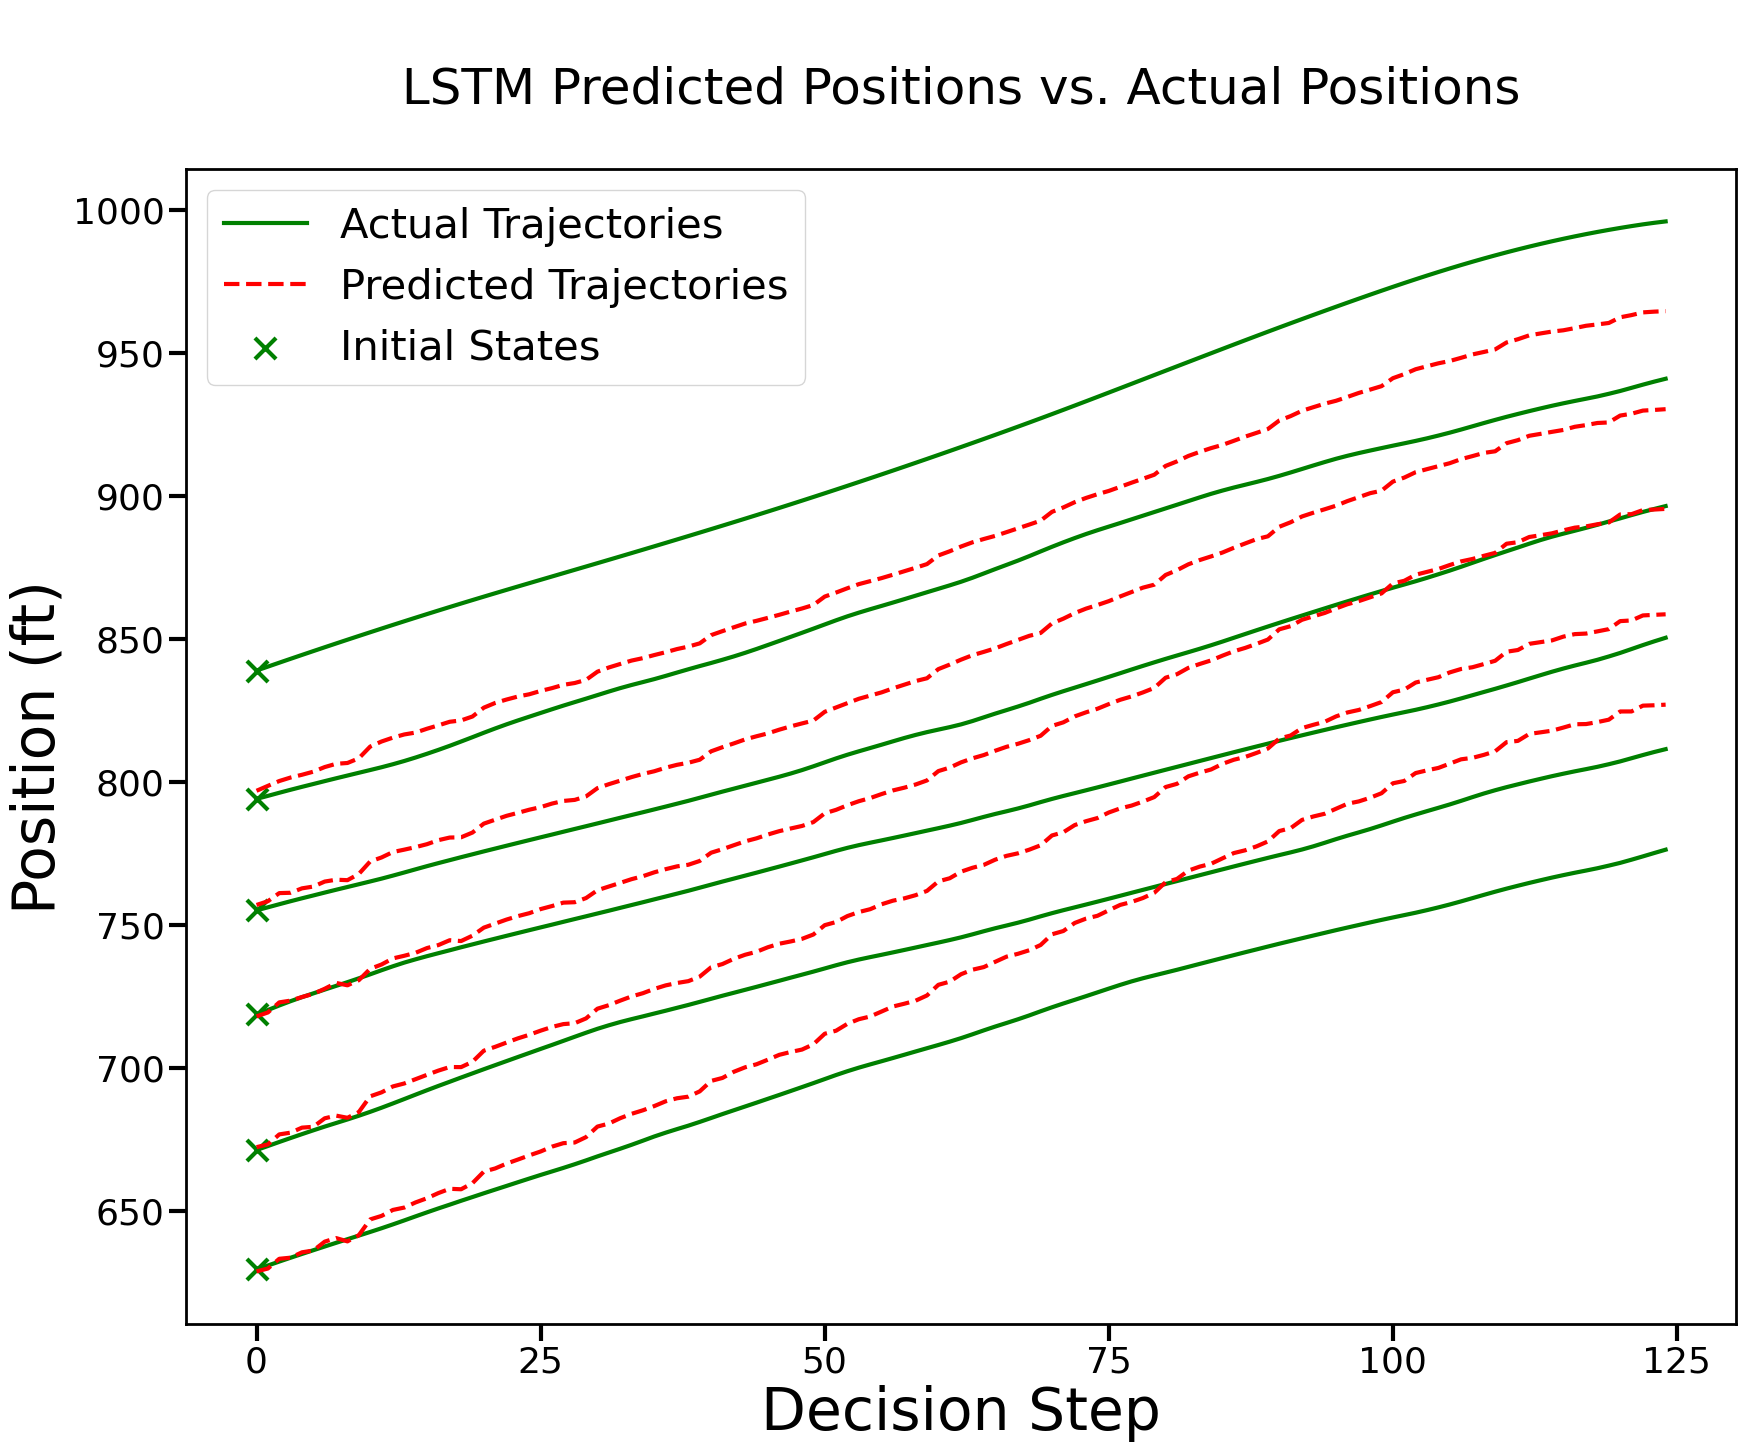

In [147]:
time = np.arange(125)
plt.figure(figsize=(20,15))
real_position = np.zeros((125,6))
for i in range(125):
    for k in range(6):
        if k == 0: # the first car = leading vehicle - first car's headway
            real_position[i,k] = cur_lead_pos[i]
        else: 
            real_position[i,k] = real_position[i,k-1] - cur_true_data[i,k-1] 

predict_position = np.zeros((125,6))
for i in range(125):
    for k in range(6):
        if k == 0: # the first car = leading vehicle - first car's headway
            predict_position[i,k] = cur_lead_pos[i]
        else:
            predict_position[i,k] = predict_position[i,k-1] - cur_pred_data[i,k-1] 

ax = plt.gca()
ax.spines['top'].set_linewidth(2)    # Top frame
ax.spines['right'].set_linewidth(2)  # Right frame
ax.spines['bottom'].set_linewidth(2) # Bottom frame
ax.spines['left'].set_linewidth(2)   # Left frame
ax.tick_params(axis='both', which='both', width=3, size=12)

plt.plot(time, real_position[:,0], linewidth=3, color='green')
initial_x = time[0]  # Initial time step
initial_y = real_position[0, 0]  # Initial position
ax.scatter(initial_x, initial_y, marker='x', s=230, linewidths = 3, color='green')

for i in range(5):
    initial_x = time[0]
    initial_y = real_position[0, i+1]
    if i == 0:
        plt.plot(time, real_position[:,i+1], label="Actual Trajectories", linewidth=3, color= 'green')
        plt.plot(time, predict_position[:,i+1], label="Predicted Trajectories", linewidth=3, linestyle="--", color='red')
        ax.scatter(initial_x, initial_y, marker='x', s=230, color='green', linewidths = 3, label=f"Initial States")
    else:
        plt.plot(time, real_position[:,i+1], linewidth=3, color='green')
        plt.plot(time, predict_position[:,i+1], linewidth=3, linestyle="--", color='red')
        ax.scatter(initial_x, initial_y, marker='x', s=230, linewidths = 3, color='green')

plt.xlabel('Decision Step',fontsize = 42)
plt.ylabel('Position (ft)',fontsize = 42)
plt.title(f'\n LSTM Predicted Positions vs. Actual Positions \n',fontsize = 36)
plt.xticks(np.arange(0, 126, 25),fontsize = 26)
plt.yticks(fontsize = 26)
plt.legend(fontsize = 30)
plt.show()

In [47]:
def lstm_predict(cur_input):
    cur_input = torch.from_numpy(cur_input).float()
    temp_input = model.forward(cur_input)
    cur_input = temp_input.reshape(temp_input.shape[0],16,10)
    temp_input = temp_input.cpu().detach().numpy()
    y_pred[0,:160] = temp_input
    y_pred[0,160:320] = temp_input
    y_temp_inv = (y_pred[0,:] - scaler.min_) / scaler.scale_
    y_inv[0,:] = y_temp_inv[:160]

    for i in range(12):
        temp_input = model.forward(cur_input)
        cur_input = temp_input.reshape(temp_input.shape[0],16,10)
        temp_input = temp_input.cpu().detach().numpy()
        y_pred[i+1,:160] = temp_input
        y_pred[i+1,160:320] = temp_input
        y_temp_inv = (y_pred[i+1,:] - scaler.min_) / scaler.scale_
        y_inv[i+1,:] = y_temp_inv[:160]  
    
    predict_data = np.zeros((125,16))
    for i in range(125):
        quo = i // 10
        rem = i % 10
        predict_data[i,:] = y_inv[quo,16*rem:16*(rem+1)]
    spacing_data = predict_data[:,1:6]
    return spacing_data
    

In [48]:
def mse(pred,true):
    sum_mse = 0
    sum_mae = 0
    for i in range(125):
        for k in range(5):
            sum_mse += (true[i,k] - pred[i,k])**2
            sum_mae += abs(true[i,k] - pred[i,k])
    return sum_mse/(125*5),sum_mae/(125*5)

In [49]:
# data preprocessing
mse_input_data = np.zeros((40,16,10))
for i in range(20):
    for k in range(2):
        mse_input_data[2*i+k,:,:] = x_pred[i,125*(k+1)-10,:,:]
# print(mse_input_data)
mse_true_data = np.zeros((40,125,5))
for i in range(20):
    for k in range(2):
        mse_true_data[2*i+k,:,:] = true_data[i,125*(k+1):125*(k+2),:]
# print(mse_true_data)

mse_sum = 0
mae_sum = 0
# predict
for i in range(40):
    cur_spacing_data = lstm_predict(mse_input_data[i:i+1,:,:])
    cur_mse,cur_mae = mse(cur_spacing_data,mse_true_data[i,:,:])
    mse_sum += cur_mse
    mae_sum += cur_mae
    mae_avg = mae_sum / 40
    
print("RMSE of LSTM:",0.3048 * np.sqrt(mse_sum/40))
print("MAE of LSTM:",0.3048 * mae_avg)

RMSE of LSTM: 10.995647321876922
MAE of LSTM: 10.72457854788436
